In [2]:
window_size = [30,60,90,180]
num_features = 88 #depends on how much features we have
output_days = 1
output_features = 2 #min and max

Base Model building

In [3]:
import tensorflow as tf
from tensorflow.keras import layers,models

In [4]:
# Time-weighted loss function definition
# Custom Time-Weighted Loss Function
# Custom Keras Loss Class
class TimeWeightedLoss(tf.keras.losses.Loss):
    def __init__(self, weights, lambda_=1.0, gamma=0.1, name="time_weighted_loss"):
        super().__init__(name=name)
        self.weights = tf.convert_to_tensor(weights, dtype=tf.float32)
        self.lambda_ = lambda_
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Split y_true and y_pred into min and max
        y_true_min, y_true_max = y_true[:, :, 1], y_true[:, :, 0]
        y_pred_min, y_pred_max = y_pred[:, :, 1], y_pred[:, :, 0]

        # Ensure weights are properly shaped
        weights = tf.reshape(self.weights, [1, 7])  # Shape for broadcasting

        # Time-weighted MSE for min and max
        mse_min = tf.reduce_mean(weights * tf.square(y_true_min - y_pred_min))
        mse_max = tf.reduce_mean(weights * tf.square(y_true_max - y_pred_max))

        # Time-weighted min-max constraint penalty
        penalty = tf.reduce_sum(weights * tf.square(tf.maximum(0.0, y_pred_min - y_pred_max)))

        # Time-weighted temporal smoothness
        smoothness_min = tf.reduce_sum(weights[:, 1:] * tf.square(y_pred_min[:, 1:] - y_pred_min[:, :-1]))
        smoothness_max = tf.reduce_sum(weights[:, 1:] * tf.square(y_pred_max[:, 1:] - y_pred_max[:, :-1]))

        # Total loss
        total_loss = (mse_min + mse_max) + self.lambda_ * penalty + self.gamma * (smoothness_min + smoothness_max)
        return total_loss

    def get_config(self):
        return {"weights": self.weights.numpy().tolist(), "lambda_": self.lambda_, "gamma": self.gamma}

# Define weights (e.g., exponential decay)
alpha = 0.7
weights = [alpha ** (d - 1) for d in range(1, 8)]

# Instantiate the custom loss
custom_loss = TimeWeightedLoss(weights=weights, lambda_=1.0, gamma=0.1)


In [5]:
def baseline_LSTM_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.LSTM(100, return_sequences=True)(inputs)
    x = layers.LSTM(100)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = baseline_LSTM_model.__name__
    
    return model, function_name

In [6]:
def baseline_GRU_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.GRU(100, return_sequences=False)(inputs)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = baseline_GRU_model.__name__
    
    return model, function_name

In [7]:
'''
CNN_LSTM mdoel is a combination of CNN and LSTM. CNN is used to extract the features from the input data and LSTM is used to support the sequence data.
'''
def CNN_LSTM_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='tanh')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='tanh')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(200)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # 7 days * 2 targets (High, Low)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = CNN_LSTM_model.__name__
    
    return model, function_name
#can use KAN, Attenion layer to adjust the weight

In [8]:
# Define the CNN + GRU model
def CNN_GRU_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='tanh')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='tanh')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=False)(x)
    x = layers.GRU(200, return_sequences=False)(x)
    
    x = layers.Dense(output_days * output_features)(x)  # Output for 7 days * 2 features (min and max)
    
    x = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs, x)
    function_name = CNN_GRU_model.__name__
    
    return model, function_name

In [9]:
from tensorflow.keras.layers import Attention
def CNN_LSTM_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    x = layers.Conv1D(filters=64, kernel_size=2, activation='tanh')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='tanh')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(100, return_sequences=True)(x)
    x = layers.LSTM(200, return_sequences=True)(x)
    
    # Attention mechanism
    attention = Attention()([x, x])
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(output_days*output_features)(x)
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_LSTM_SA_model.__name__
    return model, function_name

In [10]:
def CNN_GRU_SA_model(window_size, num_features, output_days, output_features):
    inputs = layers.Input(shape=(window_size, num_features))
    
    x = layers.Conv1D(filters=64, kernel_size=2, activation='tanh')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation='tanh')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.GRU(100, return_sequences=True)(x)
    x = layers.GRU(200, return_sequences=True)(x)
    
    attention = layers.Attention()([x, x])  # Self-attention (query = value = x)
    x = layers.Concatenate()([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(output_days * output_features)(x)
    
    outputs = layers.Reshape((output_days, output_features))(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    function_name = CNN_GRU_SA_model.__name__
    
    return model,function_name

In [11]:
def get_angles(pos, i, d_model):
    """Helper function to compute the angles for positional encoding."""
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [12]:
import numpy as np

def positional_encoding(seq_len, d_model):
    """
    Computes the sinusoidal positional encoding.

    Args:
        seq_len (int): Length of the sequence.
        d_model (int): Dimensionality of the model.

    Returns:
        tf.Tensor: Positional encoding of shape (1, seq_len, d_model).
    """
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rads = get_angles(pos, i, d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [13]:
def transformer_encoder(inputs, d_model, num_heads, ff_dim, dropout_rate):
    """
    Implements a single transformer encoder block.

    Args:
        inputs (tf.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
        d_model (int): Dimensionality of the model.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimensionality of the feed-forward network.
        dropout_rate (float): Dropout rate.

    Returns:
        tf.Tensor: Output tensor of the encoder block.
    """
    # Multi-head self-attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    # Feed-forward network
    ffn_output = tf.keras.layers.Dense(ff_dim, activation='relu')(out1)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

In [14]:
def TFT_transformer_model(window_size, num_features, output_days, output_features,
                            d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout_rate=0.1):
    """
    Builds a simplified Temporal Fusion Transformer (TFT)-inspired model for stock prediction.
    
    Args:
        window_size (int): Number of time steps in the input sequence.
        num_features (int): Number of features per time step.
        output_days (int): Number of days (time steps) to predict.
        output_features (int): Number of features to predict per day.
        d_model (int, optional): Dimensionality of the model. Default is 64.
        num_heads (int, optional): Number of attention heads in the transformer blocks. Default is 4.
        ff_dim (int, optional): Dimensionality of the feed-forward network. Default is 128.
        num_transformer_blocks (int, optional): Number of transformer encoder blocks. Default is 2.
        dropout_rate (float, optional): Dropout rate. Default is 0.1.
        
    Returns:
        tf.keras.Model: A compiled Keras model ready for training.
    """
    inputs = tf.keras.Input(shape=(window_size, num_features))
    x = tf.keras.layers.Dense(d_model)(inputs)
    pos_encoding = positional_encoding(window_size, d_model)
    x = x + pos_encoding
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, d_model, num_heads, ff_dim, dropout_rate)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(output_days * output_features)(x)
    outputs = tf.keras.layers.Reshape((output_days, output_features))(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    function_name = TFT_transformer_model.__name__
    # Return the model along with a name for saving/identification
    return model, function_name

Meta Model training 

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.models import save_model

def base_training(model_function,
                loading_path, 
                saving_path, 
                version_name, 
                seed = 42,
                test_size = 0.8,
                epochs = 20,
                batch_size = 8,
                shuffle=True, 
                metrics=['mae'],
                loss = 'mean_squared_error',
                #loss = custom_loss,
                optimizer='adam',
                window_size = window_size, 
                num_features = num_features, 
                output_days = output_days, 
                output_features = output_features):
    
    model_history = []
    models_list = []
    X_tests = []
    y_tests = []
    #create folder to save the model
    if loss == custom_loss:
        model_folder_path = os.path.join(saving_path, version_name, f"_s-{seed}_t-{test_size}_e-{epochs}_b-{batch_size}_S-{shuffle}_m-{metrics}_l-custom_o-{optimizer}")
    else:
        model_folder_path = os.path.join(saving_path, version_name, f"_s-{seed}_t-{test_size}_e-{epochs}_b-{batch_size}_S-{shuffle}_m-{metrics}_l-{loss}_o-{optimizer}")

    os.makedirs(model_folder_path, exist_ok=True)
    print(f"Folder '{version_name}' is ready.")


    for window in window_size:
        # Load the data
        X = pd.read_pickle(loading_path + f"X_{window}days_i.pkl")
        y = pd.read_pickle(loading_path + f"y_{window}days_i.pkl")
        print(f"Data for {window} days loaded.") 
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=test_size, 
                                                            shuffle=shuffle, 
                                                            random_state=seed)
        print(f"X_train dtype: {X_train.dtype}, shape: {X_train.shape}")
        print(f"y_train dtype: {y_train.dtype}, shape: {y_train.shape}")
        X_train = X_train.astype(np.float32)
        X_test = X_test.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)
        print("Data split into training and testing sets.")

        # Train the model
        print("start training:\n")
        model, name = model_function(window, 
                                     num_features, 
                                     output_days, 
                                     output_features)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        history = model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_test, y_test), 
                            verbose=1)
        
        # Save the model    
        model_save_path = os.path.join(model_folder_path, f"{name}_{window}days.h5")
        model.save(model_save_path)
        print(f"Model trained on {window} days has been saved.")
        models_list.append(model)
        model_history.append(history)
        X_tests.append(X_test)
        y_tests.append(y_test)

    return models_list, model_history, name, X_tests, y_tests
    

In [16]:
import matplotlib.pyplot as plt
def plot_training_history(model_history, window_size, name):
    for i, history in enumerate(model_history):
        plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Training Loss', color='blue')
        plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
        plt.title(f'Model Loss for {name} {window_size[i]} Days')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
    #plot prediction vs true value
    


In [17]:
#plot prediction vs true value
# def plot_predictions(model_history, X_tests, y_tests, window_size, name):
#     for id in range(len(model_history)):
#         y_pred = model_history[id].predict(X_tests[id])
#         days = range(1, output_days + 1)
        
#         for i in range(0, len(y_pred), 1000):
#             plt.figure(figsize=(14, 7))
#             plt.plot(days, y_tests[id][i, :, 0], marker='o', label='True Min', color='blue')
#             plt.plot(days, y_pred[i, :, 0], marker='o', label='Predicted Min', color='red')
#             plt.plot(days, y_tests[id][i, :, 1], marker='o', label='True Max', color='green')
#             plt.plot(days, y_pred[i, :, 1], marker='o', label='Predicted Max', color='orange')
#             plt.title(f'Min and Max Predictions for {name} {window_size[id]} Days')
#             plt.ylabel('Price')
#             plt.xlabel('Day')
#             plt.legend()
#             plt.show()


In [18]:
# #plot prediction vs true value individual smaple

# def plot_predictions(models_list, X_tests, y_tests, window_size, name):
#     """
#     Plot true vs predicted values for the model.

#     Parameters:
#         models_list (list): List of trained models.
#         X_tests (list): List of test input data.
#         y_tests (list): List of true output values.
#         window_size (list): List of window sizes used for training.
#         name (str): Name of the model.
#     """
#     for id in range(len(models_list)):
#         y_pred = models_list[id].predict(X_tests[id])
        
#         # Ensure y_tests has the correct shape
#         if len(y_tests[id].shape) == 2:
#             y_tests[id] = np.reshape(y_tests[id], (y_tests[id].shape[0], -1, 2))  # Reshape to [num_samples, sequence_length, 2]
        
#         # Days for plotting (1 to sequence_length)
#         days = range(1, y_tests[id].shape[1] + 1)
        
#         # Plot every 1000th sample for clarity
#         for i in range(0, len(y_pred), 1000):
#             plt.figure(figsize=(14, 7))
            
#             # Plot true min and max
#             plt.plot(days, y_tests[id][i, :, 0], marker='o', label='True Min', color='blue')
#             plt.plot(days, y_tests[id][i, :, 1], marker='o', label='True Max', color='green')
            
#             # Plot predicted min and max
#             plt.plot(days, y_pred[i, :, 0], marker='o', label='Predicted Min', color='red')
#             plt.plot(days, y_pred[i, :, 1], marker='o', label='Predicted Max', color='orange')
            
#             # Add titles and labels
#             plt.title(f'Min and Max Predictions for {name} (Window Size: {window_size[id]} Days)')
#             plt.ylabel('Price')
#             plt.xlabel('Day')
#             plt.legend()
#             plt.grid(True)
#             plt.show()


In [19]:
#average the prediction and plot
def plot_predictions(models_list, X_tests, y_tests, window_size, name):
    """
    Plot true vs predicted values for the model, combining all samples into one graph.

    Parameters:
        models_list (list): List of trained models.
        X_tests (list): List of test input data.
        y_tests (list): List of true output values.
        window_size (list): List of window sizes used for training.
        name (str): Name of the model.
    """
    for id in range(len(models_list)):
        y_pred = models_list[id].predict(X_tests[id])
        
        # Ensure y_tests has the correct shape
        if len(y_tests[id].shape) == 2:
            y_tests[id] = np.reshape(y_tests[id], (y_tests[id].shape[0], -1, 2))  # Reshape to [num_samples, sequence_length, 2]
        
        # Days for plotting (1 to sequence_length)
        days = range(1, y_tests[id].shape[1] + 1)
        
        # Initialize arrays to store aggregated true and predicted values
        true_min_avg = np.mean(y_tests[id][:, :, 0], axis=0)  # Average true min across samples
        true_max_avg = np.mean(y_tests[id][:, :, 1], axis=0)  # Average true max across samples
        pred_min_avg = np.mean(y_pred[:, :, 0], axis=0)       # Average predicted min across samples
        pred_max_avg = np.mean(y_pred[:, :, 1], axis=0)       # Average predicted max across samples
        
        # Create a single figure for all samples
        plt.figure(figsize=(14, 7))
        
        # Plot average true min and max
        plt.plot(days, true_min_avg, marker='o', label='True Min (Avg)', color='blue', linestyle='--')
        plt.plot(days, true_max_avg, marker='o', label='True Max (Avg)', color='green', linestyle='--')
        
        # Plot average predicted min and max
        plt.plot(days, pred_min_avg, marker='o', label='Predicted Min (Avg)', color='red', linestyle='-')
        plt.plot(days, pred_max_avg, marker='o', label='Predicted Max (Avg)', color='orange', linestyle='-')
        
        # Add titles and labels
        plt.title(f'Average Min and Max Predictions for {name} (Window Size: {window_size[id]} Days)')
        plt.ylabel('Price')
        plt.xlabel('Day')
        plt.legend()
        plt.grid(True)
        plt.show()

In [74]:
function_list = [baseline_LSTM_model, 
                 baseline_GRU_model, 
                 CNN_LSTM_model, 
                 CNN_GRU_model, 
                 CNN_LSTM_SA_model, 
                 CNN_GRU_SA_model,
                 TFT_transformer_model
                 ]
for model_function in function_list:
    print(f"Training {model_function.__name__} model.")
    print(model_function)
    models_list, model_history, name, X_tests, y_tests = base_training(model_function, 
                                                        loading_path = "data/", 
                                                        saving_path="saved models/",
                                                        version_name="20250207_90_features_precentages",
                                                        seed = 42,
                                                        test_size = 0.8,
                                                        epochs = 20,
                                                        batch_size = 8,
                                                        shuffle=True, 
                                                        metrics=['mae'],
                                                        loss = 'mean_squared_error',
                                                        #loss = custom_loss,
                                                        optimizer='adam',
                                                        window_size = window_size, 
                                                        num_features = num_features, 
                                                        output_days = output_days, 
                                                        output_features = output_features
                                                        )
    plot_training_history(model_history, window_size, name)
    plot_predictions(models_list, X_tests, y_tests, window_size, name)
    

Training baseline_LSTM_model model.
<function baseline_LSTM_model at 0x322048ae0>
Folder '20250207_90_features_precentages' is ready.
Data for 30 days loaded.
X_train dtype: object, shape: (1772, 30, 88)
y_train dtype: float64, shape: (1772, 2)
Data split into training and testing sets.
start training:

Epoch 1/20
 99/222 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0114 - mae: 0.0690

KeyboardInterrupt: 

Build ensemble model with meta mode (transfer learning/fine-tuning), since will do back propaggation through the ensemble layer all the way to the individual model, we can use multiple stock training data for the individual model, increase the generalization, and do the tuning with the target data, in the ensemble layer training part

In [30]:
from tensorflow.keras.models import Model
def ensemble_stacking (models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    merged_output = layers.concatenate(models_outputs, axis=-1)
    #searching method for removing the last layer of the model, and directly inputting weight into stackinng model
    
    #stacking model
    merged_output = layers.Dense(64, activation='relu')(merged_output)
    merged_output = layers.Dense(output_days * output_features)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model


    

In [22]:
def ensemble_weighting (models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    merged_output = layers.Add()(models_outputs)
    merged_output = layers.Dense(output_days*output_features)(merged_output)
    final_output = layers.Reshape((output_days, output_features))(merged_output)
    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model


In [23]:
#need more understanding on the MoE
''' stacking is y_p = sum(w*y_i)
    MoE is y_p = sum(g_i*y_i)
    can add other function model, like anomaly detection, to the ensemble model, since most of the data is normal, the model can be used to detect the anomaly data(Event)
'''

def ensemble_MoE(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics):
    # Step 1: Concatenate the outputs of all the experts
    concatenated_experts = layers.concatenate(models_outputs)
    # Step 2: Apply a gate to weight the expert outputs
    gate = layers.Dense(len(models_outputs), activation='softmax')(concatenated_experts)
    # Step 3: Multiply the gate with the expert outputs
    weighted_experts = [layers.Multiply()([gate[:, i:i+1], models_outputs[i]]) for i in range(len(models_outputs))]
    # Step 4: Sum the weighted expert outputs
    final_expert_output = layers.Add()(weighted_experts)
    # Step 5: Reshape the final output to the desired shape
    final_output = layers.Reshape((output_days, output_features))(final_expert_output)
    # Step 6: Define the ensemble model
    ensemble_model = models.Model(inputs=models_inputs, outputs=final_output)
    # Step 7: Compile the model
    ensemble_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return ensemble_model

In [24]:
#function to load models in provided path
from tensorflow.keras.models import load_model
def load_models(path, remove_last_layer=False):
    """
    Load all models from a specified directory.

    Parameters:
        path (str): Path to the directory containing the saved models.
        remove_last_layer (bool): Whether to remove the last layer of the model.

    Returns:
        original_models (list): List of loaded models.
        models_inputs (list): List of model input shapes.
        models_outputs (list): List of model output shapes.
        models_order (list): List of model filenames in the order they were loaded.
    """
    original_models = []
    models_inputs = []
    models_outputs = []
    models_order = []

    # Define custom objects (e.g., custom loss functions)
    custom_objects = {'TimeWeightedLoss': TimeWeightedLoss(weights=weights, lambda_=1.0, gamma=0.1)}

    # Load each model in the directory
    for file in sorted(os.listdir(path)):
        if file.endswith(".h5"):
            try:
                # Load the model with custom objects
                model = load_model(os.path.join(path, file), custom_objects=custom_objects)
                models_order.append(file)
                print(f"Model loaded: {os.path.join(path, file)}")

                # Store model input and output shapes
                models_inputs.append(model.input_shape)
                models_outputs.append(model.output_shape)

                # Optionally remove the last layer
                if remove_last_layer:
                    model.layers.pop()

                original_models.append(model)
            except Exception as e:
                print(f"Error loading model {file}: {e}")

    return original_models, models_inputs, models_outputs, models_order



In [25]:
def ensemble_model_training(models_inputs, models_outputs, output_days, output_features, model_type = "stacking", optimizer='adam', loss='mean_squared_error', metrics=['mae']):
    if model_type == 'stacking':
        ensemble_model = ensemble_stacking(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    elif model_type == 'weighting':
        ensemble_model = ensemble_weighting(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    elif model_type == 'MoE':
        ensemble_model = ensemble_MoE(models_inputs, models_outputs, output_days, output_features, optimizer, loss, metrics)
    else:
        print("Please provide a valid model type.")
        return None
    return ensemble_model

In [26]:
#load the whole folder of models (you might have multiple floders of models, then need multiple load_models function and do the selection in the next cell)
orginal_models, models_inputs, models_outputs, models_order = load_models("saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam")

Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_180days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_30days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_60days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_SA_model_90days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_180days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_30days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-Tru

Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_GRU_model_90days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_180days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_30days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_60days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_90days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_180days.h5


Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_30days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_60days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_90days.h5
Error loading model TFT_transformer_model_180days.h5: too many positional arguments
Error loading model TFT_transformer_model_30days.h5: too many positional arguments
Error loading model TFT_transformer_model_60days.h5: too many positional arguments
Error loading model TFT_transformer_model_90days.h5: too many positional arguments
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_GRU_model_180days.h5


Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_GRU_model_30days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_GRU_model_60days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_GRU_model_90days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_180days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_30days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/baseline_LSTM_model_60days.h5
Model loaded: saved models/20250207_90_features_precentages/_s-42_

In [27]:
#select the models(4 models Time-based) and ensemble method you want and feed into the ensemble traing function
#if stargetry changed, the function and training set need to updatye too 
print(models_order)
print(models_inputs)

['CNN_GRU_SA_model_180days.h5', 'CNN_GRU_SA_model_30days.h5', 'CNN_GRU_SA_model_60days.h5', 'CNN_GRU_SA_model_90days.h5', 'CNN_GRU_model_180days.h5', 'CNN_GRU_model_30days.h5', 'CNN_GRU_model_60days.h5', 'CNN_GRU_model_90days.h5', 'CNN_LSTM_SA_model_180days.h5', 'CNN_LSTM_SA_model_30days.h5', 'CNN_LSTM_SA_model_60days.h5', 'CNN_LSTM_SA_model_90days.h5', 'CNN_LSTM_model_180days.h5', 'CNN_LSTM_model_30days.h5', 'CNN_LSTM_model_60days.h5', 'CNN_LSTM_model_90days.h5', 'baseline_GRU_model_180days.h5', 'baseline_GRU_model_30days.h5', 'baseline_GRU_model_60days.h5', 'baseline_GRU_model_90days.h5', 'baseline_LSTM_model_180days.h5', 'baseline_LSTM_model_30days.h5', 'baseline_LSTM_model_60days.h5', 'baseline_LSTM_model_90days.h5']
[(None, 180, 88), (None, 30, 88), (None, 60, 88), (None, 90, 88), (None, 180, 88), (None, 30, 88), (None, 60, 88), (None, 90, 88), (None, 180, 88), (None, 30, 88), (None, 60, 88), (None, 90, 88), (None, 180, 88), (None, 30, 88), (None, 60, 88), (None, 90, 88), (None, 1

In [28]:
#be aware of the order, it need to be 7, 14, 30, 60 from small to large
models_inputs_selected = [models_inputs[models_order.index("CNN_LSTM_model_30days.h5")], models_inputs[models_order.index("CNN_LSTM_model_60days.h5")], models_inputs[models_order.index("CNN_LSTM_model_90days.h5")], models_inputs[models_order.index("CNN_LSTM_model_180days.h5")]]   
models_outputs_selected = [models_outputs[models_order.index("CNN_LSTM_model_30days.h5")], models_outputs[models_order.index("CNN_LSTM_model_60days.h5")], models_outputs[models_order.index("CNN_LSTM_model_90days.h5")], models_outputs[models_order.index("CNN_LSTM_model_180days.h5")]]

In [31]:
#select the models(4 models Time-based) and ensemble method you want and feed into the ensemble traing function
#if stargetry changed, the function and training set need to updatye too 
ensemble_s_model = ensemble_model_training(models_inputs_selected, 
                                           models_outputs_selected, 
                                           output_days, 
                                           output_features, 
                                           model_type = "stacking", 
                                           optimizer='adam', 
                                           loss="mean_squared_error", 
                                           metrics=['mae'])

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 1 (of type <class 'int'>)

In [52]:
ensemble_w_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "weighting", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 1 (of type <class 'int'>)

In [53]:
ensemble_MoE_model = ensemble_model_training(models_inputs_selected, models_outputs_selected, output_days, output_features, model_type = "MoE", optimizer='adam', loss='mean_squared_error', metrics=['mae'])

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 1 (of type <class 'int'>)

In [34]:
#loading the data for testing in ensemble model

def load_data(window_size = window_size, path = f"data", test_size = 0.8, shuffle = True, seed = 42):
    all_X_train = []
    all_X_test = []
    all_y_train = []
    all_y_test = []
    
    y = pd.read_pickle(f"{path}/y_a.pkl")
    for window in window_size:
        X = pd.read_pickle(f"{path}/X_{window}days_a.pkl")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
        all_X_train.append(X_train)
        all_X_test.append(X_test)
        all_y_train.append(y_train)
        all_y_test.append(y_test)
    return all_X_train, all_X_test, all_y_train, all_y_test

In [55]:
all_X_train, all_X_test, all_y_train, all_y_test = load_data(path = f"data", test_size = 0.8, shuffle = True, seed = 42)

In [53]:
#fit the ensemble model
def ensemble_model_fit(ensemble_model, all_X_train, all_y_train, epochs, batch_size, save_model_path, folder_name):
    history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, verbose=1)
    #create floder to save the model
    save_model_path = os.path.join(save_model_path, folder_name)
    # Save the model
    params = f"ensemble_e-{epochs}_b-{batch_size}"
    os.makedirs(os.path.join(save_model_path, params ), exist_ok=True)
    name = ensemble_model.name
    ensemble_model.save(os.path.join(os.path.join(save_model_path, folder_name, params ),f"{name}.h5"))
    return history

In [ ]:
#traing the ensemble model
ensemble_s_model_history = ensemble_model_fit( ensemble_MoE_model, all_X_train, all_y_train, epochs = 20, batch_size = 8, save_model_path = "saved models",folder_name  = "20250207_35_features_price")


Epoch 1/20


ValueError: Input 0 of layer "functional_30" is incompatible with the layer: expected shape=(None, 7, 8), found shape=(None, 30, 35)

# Since the pipeline doesn't work after modifying the datapipeline, therefore trying manually

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model

# Load pre-trained models
model_1 = load_model("saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_30days.h5")
model_2 = load_model("saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_60days.h5")
model_3 = load_model("saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_model_90days.h5")
model_4 = load_model("saved models/20250207_90_features_precentages/_s-42_t-0.8_e-20_b-8_S-True_m-['mae']_l-mean_squared_error_o-adam/CNN_LSTM_SA_model_180days.h5")

# Remove the last layer from each model to use the intermediate output
model_1_output = model_1.layers[-2].output  # Second to last layer
model_2_output = model_2.layers[-2].output
model_3_output = model_3.layers[-2].output
model_4_output = model_4.layers[-2].output

# Concatenate the outputs from all models
merged_output = layers.concatenate([model_1_output, model_2_output, model_3_output, model_4_output], axis=-1)

# Add further dense layers for stacking
merged_output = layers.Dense(64, activation='relu')(merged_output)
merged_output = layers.Dense(2)(merged_output)  # Final output (1, 2) for each prediction
final_output = layers.Reshape((1, 2))(merged_output)  # Reshape to (1, 2)

# Define the ensemble model
ensemble_model = Model(inputs=[model_1.input, model_2.input, model_3.input, model_4.input], outputs=final_output)

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the ensemble model
ensemble_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 180, 88)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 179, 64)   │     11,328 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 89, 64)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 30, 88)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 60, 88)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 90, 88)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 88, 128)   │     16,512 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 29, 64)    │     11,328 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 59, 64)    │     11,328 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 89, 64)    │     11,328 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 44, 128)   │          0 │ conv1d_7[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 14, 64)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 29, 64)    │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 44, 64)    │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 44, 100)   │     91,600 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 13, 128)   │     16,512 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 28, 128)   │     16,512 │ max_pooling1d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 43, 128)   │     16,512 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 44, 200)   │    240,800 │ lstm_20[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 6, 128)    │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 1,443,674 (5.51 MB)

 Trainable params: 1,443,674 (5.51 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
all_X_train, all_X_test, all_y_train, all_y_test = load_data(path = f"data", test_size = 0.8, shuffle = True, seed = 42)

In [54]:
all_y_train.shape

(4, 891, 2)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 4.2601e-04 - mae: 0.0150 - val_loss: 4.2901e-04 - val_mae: 0.0144
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - loss: 4.1410e-04 - mae: 0.0144 - val_loss: 4.2682e-04 - val_mae: 0.0144
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - loss: 4.2258e-04 - mae: 0.0146 - val_loss: 4.4245e-04 - val_mae: 0.0155
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - loss: 4.1119e-04 - mae: 0.0149 - val_loss: 4.2876e-04 - val_mae: 0.0146
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - loss: 4.0799e-04 - mae: 0.0145 - val_loss: 4.2585e-04 - val_mae: 0.0148
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 3.9719e-04 - mae: 0.0145 - val_loss: 4.4302e-04 - val_mae: 0.0143
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - loss: 3.6645e-04 - mae: 0.0140 - val_loss: 4.4441e-04 - val_mae: 0.0158
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - loss: 4.1174e-04 - mae: 0.0149 - val_los

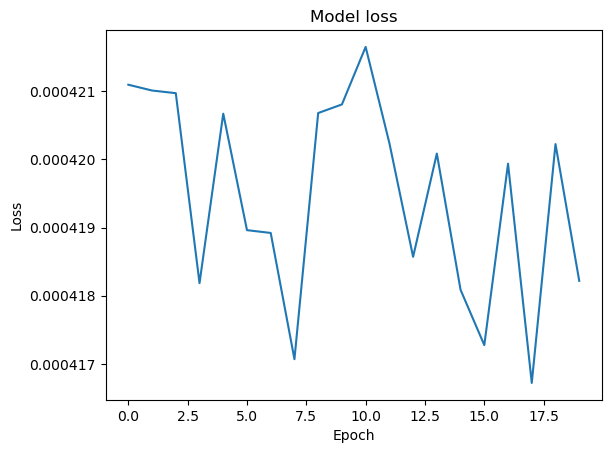

In [ ]:
# Ensure all inputs are NumPy arrays of the correct type
all_X_train = [np.array(input_data, dtype=np.float32) for input_data in all_X_train]
all_y_train = np.array(all_y_train, dtype=np.float32)  # Ensure y_train is of shape (num_samples, 2)
all_X_test = [np.array(input_data, dtype=np.float32) for input_data in all_X_test]
all_y_test = np.array(all_y_test, dtype=np.float32)

# Train the ensemble model
history = ensemble_model.fit(
    [all_X_train[0], all_X_train[1], all_X_train[2], all_X_train[3]],  # Inputs
    all_y_train[0],  # Output (min and max values)
    validation_data=(all_X_test, all_y_test[0]),
    epochs=20,
    batch_size=8,
    verbose=1
)

# Visualize the training history and validate the predictions
import matplotlib.pyplot as plt

# Example of plotting the training loss/accuracy (you can modify based on your needs)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#plot the prediction
# Make predictions using the ensemble model
#y_pred = ensemble_model.predict([all_X_test[0], all_X_test[1], all_X_test[2], all_X_test[3]])



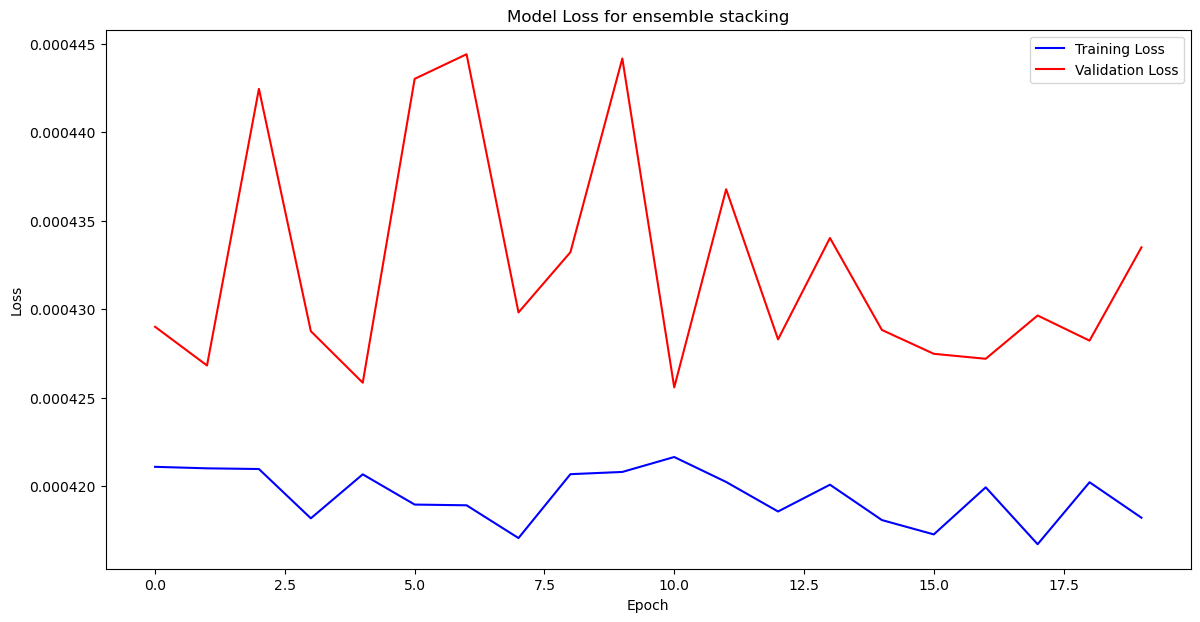

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title(f'Model Loss for ensemble stacking')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [101]:
print("y_tests shape:", y_tests.shape)
print("y_pred shape:", y_pred.shape)

NameError: name 'y_tests' is not defined

In [117]:

import matplotlib.pyplot as plt
def plot_predictions(ensemble_model, all_X_test, y_tests):
    """
    Plot true vs predicted values for the model, combining all samples into one graph.

    Parameters:
        ensemble_model (object): The trained ensemble model.
        all_X_test (array): Test input data (shape: [n_samples, sequence_length, features]).
        y_tests (array): True output values (shape: [n_samples, sequence_length, 2]).
    """
    # Make predictions for all test samples
    y_pred = ensemble_model.predict(all_X_test)  # Ensure all_X_test has shape (4, 3568, features)
    print("y_pred shape:", y_pred.shape)
    print("y_tests shape:", y_tests.shape)
    print(y_tests)
    print(y_pred)
    # Check if y_pred needs reshaping to match the shape of y_tests

    # Days for plotting (1 to sequence_length)
    days = range(1, y_tests.shape[1] + 1)

    # Initialize arrays to store aggregated true and predicted values
    true_min_avg = np.mean(y_tests[1, :, 0], axis=0)  # Average true min across samples
    true_max_avg = np.mean(y_tests[1, :, 1], axis=0)  # Average true max across samples
    pred_min_avg = np.mean(y_pred[:, :, 0], axis=0)   # Average predicted min across samples
    pred_max_avg = np.mean(y_pred[:, :, 1], axis=0)   # Average predicted max across samples

    # Create a single figure for all samples
    plt.figure(figsize=(14, 7))

    # Plot average true min and max
    plt.plot(true_min_avg, marker='o', label='True Min (Avg)', color='blue', linestyle='--')
    plt.plot(true_max_avg, marker='o', label='True Max (Avg)', color='green', linestyle='--')

    # Plot average predicted min and max
    plt.plot(pred_min_avg, marker='o', label='Predicted Min (Avg)', color='red', linestyle='-')
    plt.plot(pred_max_avg, marker='o', label='Predicted Max (Avg)', color='orange', linestyle='-')

    # Add titles and labels
    plt.title(f'Average Min and Max Predictions for ensemble stacking')
    plt.ylabel('Price')
    plt.xlabel('Day')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:
# ensemble_model = <your_trained_ensemble_model>
# all_X_test = <your_test_input_data>  # Shape: (4, 3568, features)
# y_tests = <your_true_test_labels>    # Shape: (4, 3568, 2)
# plot_predictions(ensemble_model, all_X_test, y_tests)

    

112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
y_pred shape: (3568, 1, 2)
y_tests shape: (4, 3568, 2)
[[[ 0.0237932   0.06783345]
  [ 0.00169159  0.04846482]
  [-0.03288284 -0.00197982]
  ...
  [-0.0083196   0.03912458]
  [-0.01874403  0.04256202]
  [ 0.00298963  0.04016959]]

 [[ 0.0237932   0.06783345]
  [ 0.00169159  0.04846482]
  [-0.03288284 -0.00197982]
  ...
  [-0.0083196   0.03912458]
  [-0.01874403  0.04256202]
  [ 0.00298963  0.04016959]]

 [[ 0.0237932   0.06783345]
  [ 0.00169159  0.04846482]
  [-0.03288284 -0.00197982]
  ...
  [-0.0083196   0.03912458]
  [-0.01874403  0.04256202]
  [ 0.00298963  0.04016959]]

 [[ 0.0237932   0.06783345]
  [ 0.00169159  0.04846482]
  [-0.03288284 -0.00197982]
  ...
  [-0.0083196   0.03912458]
  [-0.01874403  0.04256202]
  [ 0.00298963  0.04016959]]]
[[[-0.01415572  0.0201155 ]]

 [[-0.01415755  0.02011717]]

 [[-0.01416228  0.02012009]]

 ...

 [[-0.01415149  0.02009575]]

 [[-0.01415796  0.02011743]]

 [[-0.01416693  0.02012584]]]


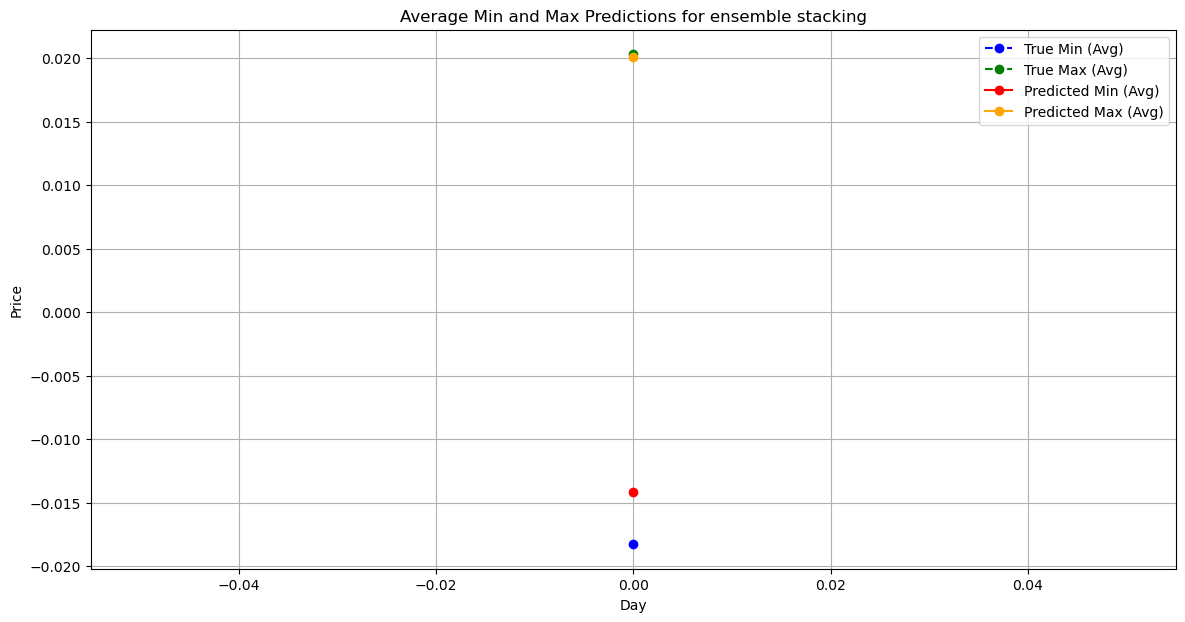

In [118]:
#plot the prediction
plot_predictions(ensemble_model, all_X_test, all_y_test)


In [50]:
print(f"Shape of all_y_train: {all_y_train.shape}")

Shape of all_y_train: (2,)


In [65]:
plot_predictions([ensemble_model], 
                 X_tests=[all_X_test[0], all_X_test[1], all_X_test[2], all_X_test[3]], 
                 y_tests=[all_y_test[0], all_y_test[1], all_y_test[2], all_y_test[3]], 
                window_size=["full"],
                name=["ensemble"])

ValueError: Layer "functional_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(32, 30, 88) dtype=float32>]

In [57]:
plot_predictions([ensemble_model], [all_X_test], [all_y_test], ["full"], ["ensemble"])

ValueError: Invalid dtype: object

### the following 3 cell can skip, theey are old version for reference

In [ ]:
#load the model and predict and save the prediction
#for window in window_size:
#    model = tf.keras.models.load_model(f"CNN_LSTM_{window}days.h5")
#    y_pred = model.predict(X_test)
#    pd.DataFrame(y_pred).to_csv(f"y_pred_CNN_LSTM_{window}days.csv")

In [ ]:
#putting all windows prediction into the dataframe as X
#import numpy as np
#X_ensemble = pd.DataFrame()
#for window in window_size:
#    X_ensemble = pd.concat([X_ensemble, pd.read_csv(f"y_pred_CNN_LSTM_{window}days.csv")], axis=1)
#    #combein the columns, so that can be used as input for the ensemble model
#   X_ensemble = X_ensemble.applymap(lambda x: np.vstack(x))

They can combein in 1 for loop, I just split it for clear

In [ ]:
#def train_test_split_ensemble(X,y,test_size=0.5, seed=42):    
#    #split again for the prediction model and the ensemble model
#    #Since we already shuffled the data, we can just split the data in half, and easaier to manage
#    X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=seed)
#    return X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble

In [ ]:
#X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split_ensemble(X_ensemble, y_test)

### Ensemble Model (TBC)

In [3]:
#from tensorflow.keras.models import Model
#def ensemble_CNN_LSTM(window_size, num_features):
#    inputs = layers.Input(shape=(window_size, num_features))
#    x = layers.Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(x)
#    x = layers.MaxPooling1D(pool_size=2)(x)
#    x = layers.LSTM(100)(x)
#    model = Model(inputs=inputs, outputs=x)
#    return model

In [ ]:
#def ensemble_s_models(window_size, num_features, output_days, output_features):
#        models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)

In [ ]:
#def ensemble_MoE_models(window_size, num_features, output_days, output_features):


In [4]:
#def ensemble_h_models(window_size, num_features, output_days, output_features):
#    models = []
#    for window in window_size:
#        model = ensemble_CNN_LSTM(window, num_features)
#        models.append(model)
#    models_inputs = [model.input for model in models]
#    models_outputs = [model.output for model in models]
#   merged = layers.concatenate(models_outputs, axis=-1)
#    merged_output = layers.Dense(output_days * output_features)(merged)
#    final_output = layers.Reshape((output_days, output_features))(merged_output)
#    ensemble_model = Model(inputs=models_inputs, outputs=final_output)
#    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#
#    return ensemble_model

In [6]:
#from sklearn.model_selection import train_test_split
#import pandas as pd
#seed = 42
#test_size = 0.8 # we need to consider for the ensemble model's training and ttesting data, since it cannot use the same training data
#epochs = 20
#batch_size = 8
#shuffle=True
#all_X_train = []
#all_X_test = []
#all_y_train = []
#all_y_test = []
#
#y = pd.read_pickle(f"/Users/hoyinchui/Downloads/y_a.pkl")
#for window in window_size:
#    X = pd.read_pickle(f"/Users/hoyinchui/Downloads/X_{window}days_a.pkl")
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle, random_state=seed)
#    all_X_train.append(X_train)
#    all_X_test.append(X_test)
#    all_y_train.append(y_train)
#    all_y_test.append(y_test)
#
##ensemble_model = ensemble_h_models(window_size, num_features, output_days, output_features)
##history = ensemble_model.fit(all_X_train, all_y_train[0], epochs=epochs, batch_size=batch_size, validation_data=(all_X_test, all_y_test[0]), verbose=1)
##ensemble_model.save(f"ensemble_CNN_LSTM.h5")
#

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0279 - mae: 0.1027 - val_loss: 5.5140e-04 - val_mae: 0.0176
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.2824e-04 - mae: 0.0169 - val_loss: 4.1390e-04 - val_mae: 0.0154
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 5.1239e-04 - mae: 0.0167 - val_loss: 4.6971e-04 - val_mae: 0.0162
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 4.3028e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.6607e-04 - mae: 0.0210 - val_loss: 4.8477e-04 - val_mae: 0.0170
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.1826e-04 - mae: 0.0152 - val_loss: 3.3729e-04 - val_mae: 0.0135
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.9106e-04 - mae: 0.0147 - val_loss: 5.9622e-04 - val_mae: 0.0190
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.8556e-04 - mae: 0.0144 - val_loss: 3.2576e-04 - val_mae: